# Problem 3
Authors: Sid Murching, Suraj Nair, Alex Cui

In [ ]:
import numpy as np
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/psets/set5/data/dr_seuss.txt', 'data.txt')
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
import sys

In [ ]:
import numpy as np

##########################
# Helper functions/classes
##########################

class WordPair:
    """
    Class representing a pair of words in our vocabulary, along with the cosine similarity
    of the two words.
    """
    def __init__(self, firstWord, secondWord, similarity):
        """
        Initializes the WordPair given two words (strings) and their similarity (float).
        """
        # Ensure that our pair consists of two distinct words
        assert(firstWord != secondWord)
        self.firstWord = firstWord
        self.secondWord = secondWord
        self.similarity = similarity

    def __repr__(self):
        """
        Define the string representation of a WordPair so that a WordPair instance x
        can be displayed using print(x).
        """
        return "Pair(%s, %s), Similarity: %s"%(self.firstWord, self.secondWord, self.similarity)


def sort_by_similarity(word_pairs):
    """
        Given a list of word pair instances, returns a list of the instances sorted
        in decreasing order of similarity.
    """
    return sorted(word_pairs, key=lambda pair: pair.similarity, reverse=True)

def get_similarity(v1, v2):
    """ 
        Returns the cosine of the angle between vectors v1 and v2
    """
    v1_unit = v1 / np.linalg.norm(v1)
    v2_unit = v2 / np.linalg.norm(v2)
    return np.dot(v1_unit, v2_unit)


def load_word_list(filename):
    """
        Loads a list of the words from the url, removing all
        non-alpha-numeric characters from the file.
    """
    handle = open('data.txt', 'r')
    # Load a list of whitespace-delimited words from the specified file
    raw_text = handle.read().strip().split()
    # Strip non-alphanumeric characters from each word
    alphanumeric_words = map(lambda word: ''.join(char for char in word if char.isalnum()), raw_text)
    # Filter out words that are now empty (e.g. strings that only contained non-alphanumeric chars)
    alphanumeric_words = filter(lambda word: len(word) > 0, alphanumeric_words)
    # Convert each word to lowercase and return the result

    handle.close()
    return list(map(lambda word: word.lower(), alphanumeric_words))


def generate_onehot_dict(word_list):
    """
        Takes a list of the words in a text file, returning a dictionary mapping
        words to their index in a one-hot-encoded representation of the words.
    """
    word_to_index = {}
    i = 0
    for word in word_list:
        if word not in word_to_index:
            word_to_index[word] = i
            i += 1
    return word_to_index

def most_similar_pairs(weight_matrix, word_to_index):
    """
        For each word a in our vocabulary, computes the most similar word b to a, along with the
        cosine similarity of a and b.

    Arguments:
        weight_matrix: The matrix of weights extracted from the hidden layer of a fitted
                       neural network.

        word_to_index: Dictionary mapping words to their corresponding index
                       in a one-hot-encoded representation of our corpus.

    Returns: 
        A list of WordPair instances sorted in decreasing order of similarity,
        one representing each word <vocab_word> and its most similar word.
    """
    word_to_feature_repr = get_word_to_feature_repr(weight_matrix, word_to_index)
    result = []
    for word in word_to_feature_repr:
        result.append(most_similar_word(word_to_feature_repr, word))
    return sort_by_similarity(result)

def most_similar_word(word_to_feature_repr, input_word):
    """
        Given a dictionary mapping words to their feature representations (word_to_feature_repr),
        returns the a WordPair instance corresponding to the word
        whose feature vector is most similar to the feature representation of the
        passed-in word (input_word).

        Note that similarity is defined as cosine projections, not euclidean distance
    """
    best_word = None
    best_similarity = 0
    input_vec = word_to_feature_repr[input_word]
    for word, feature_vec in word_to_feature_repr.items():
        similarity = get_similarity(input_vec, feature_vec)
        if similarity > best_similarity and np.linalg.norm(feature_vec - input_vec) != 0:
            best_similarity = similarity
            best_word = word
    return WordPair(input_word, best_word, best_similarity)

def get_word_to_feature_repr(weight_matrix, word_to_index):
    """
        Returns a dictionary mapping each word in our vocabulary to its one-hot-encoded
        feature representation.

        Arguments:
            weight_matrix: The matrix of weights extracted from the hidden layer of a fitted
                       neural network.

            word_to_index: Dictionary mapping words to their corresponding index
                       in a one-hot-encoded representation of our corpus.
    """
    assert(weight_matrix is not None)
    word_to_feature_repr = {}
    for word, one_hot_idx in word_to_index.items():
        word_to_feature_repr[word] = weight_matrix[one_hot_idx]
    return word_to_feature_repr

### Data preparation
1. Generate one-hot encoding for each word
2. Generate skip-gram traing set with window size s=2. That is, each word corresponds to a context consisitng of only one neighboring word. This training set is equivalent to a collection of neighboring word pais. Graphically: 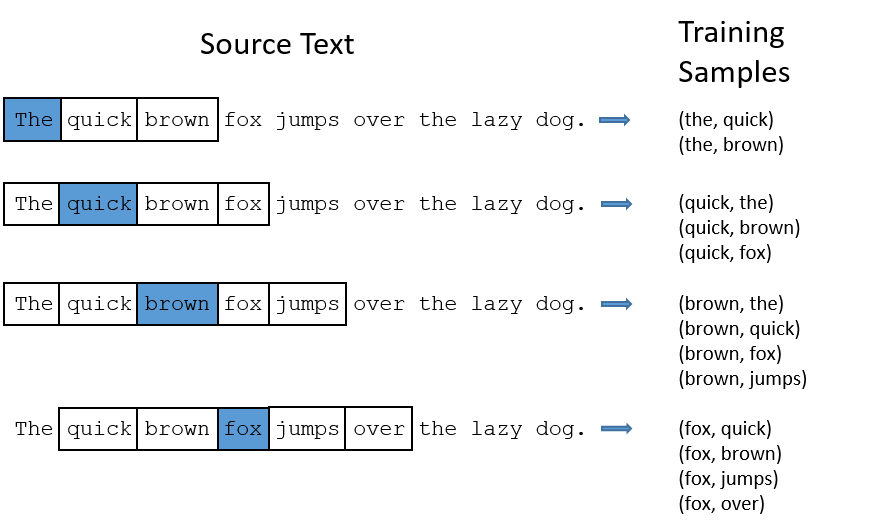

In [ ]:
def get_word_repr(word_to_index, word):
    """
        Returns one-hot-encoded feature representation of the specified word given
        a dictionary mapping words to their one-hot-encoded index.

        Arguments:
            word_to_index: Dictionary mapping words to their corresponding index
                       in a one-hot-encoded representation of our corpus.

            word:          String containing word whose feature representation we wish to compute.

        Returns:
            feature_representation:     Feature representation of the passed-in word.
    """
    unique_words = word_to_index.keys()
    # Return a vector that's zero everywhere besides the index corresponding to <word>
    feature_representation = np.zeros(len(unique_words))
    feature_representation[word_to_index[word]] = 1
    return feature_representation    

def generate_traindata(word_list, word_to_index, window_size=4):
    """
        Generates training data for Skipgram model.

        Arguments:
            word_list:     Sequential list of words (strings).
            word_to_index: Dictionary mapping words to their corresponding index
                        in a one-hot-encoded representation of our corpus.

            window_size:   Size of Skipgram window.
                        (use the default value when running your code).

        Returns:
            (trainX, trainY):     A pair of matrices (trainX, trainY) containing training 
                                points (one-hot-encoded vectors representing individual words) and 
                                their corresponding labels (also one-hot-encoded vectors representing words).

                                For each index i, trainX[i] should correspond to a word in
                                <word_list>, and trainY[i] should correspond to one of the words within
                                a window of size <window_size> of trainX[i].
    """
    trainX = []
    trainY = []
    length = len(word_list)
    for i in range(length):
        for j in range(max(0,i-window_size),i):
            trainX += [get_word_repr(word_to_index, word_list[i])]
            trainY += [get_word_repr(word_to_index, word_list[j])]
        for j in range(i+1,min(i+1+window_size,length)):
            trainX += [get_word_repr(word_to_index, word_list[i])]
            trainY += [get_word_repr(word_to_index, word_list[j])]

    return (np.array(trainX), np.array(trainY))

In [ ]:
def find_most_similar_pairs(filename, num_latent_factors):
    """
        Find the most similar pairs from the word embeddings computed from
        a body of text
        
        Arguments:
            filename:           Text file to read and train embeddings from
            num_latent_factors: The number of latent factors / the size of the embedding
    """
    # Load in a list of words from the specified file; remove non-alphanumeric characters
    # and make all chars lowercase.
    sample_text = load_word_list(filename)

    # Create dictionary mapping unique words to their one-hot-encoded index
    word_to_index = generate_onehot_dict(sample_text)
    # Create training data using default window size
    trainX, trainY = generate_traindata(sample_text, word_to_index, window_size=4)
    '''
    Create and train model in Keras.  
    '''    
    # vocab_size = number of unique words in our text file. Will be useful when adding layers
    # to your neural network
    vocab_size = len(word_to_index)
    model = Sequential()

    # first layer vocab_size -> num_latent_factors
    # no activations, completely linear
    model.add(Dense(num_latent_factors, input_dim = vocab_size))

    # second layer num_latent_factors -> vocab_size 
    # softmax activation
    model.add(Dense(vocab_size, activation='softmax'))

    model.summary()

    # Compile and Train
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(trainX, trainY, epochs=100, batch_size=10)

    '''
    Extract weights for hidden layer, set <weights> variable below.
    Since input words are one-hot coded as horizontal vectors, the weight
    matrix becomes a lookup table for each word's latent vector 
    '''
    # print(model.layers[0].get_weights()[0].shape)
    weights = model.layers[0].get_weights()[0]

    # Find and print most similar pairs
    similar_pairs = most_similar_pairs(weights, word_to_index)
    for pair in similar_pairs[:30]:
        print(pair)

### Training
Runing and printing most similar word pairs from dr_seuss.txt.

In [ ]:
find_most_similar_pairs('data.txt', 10)


Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 10)                3090      
_________________________________________________________________
dense_95 (Dense)             (None, 308)               3388      
Total params: 6,478
Trainable params: 6,478
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1655/1655 [==============================] - 3s 1ms/step - loss: 5.2473 - accuracy: 0.0484
Epoch 2/100
1655/1655 [==============================] - 2s 1ms/step - loss: 4.7596 - accuracy: 0.0592
Epoch 3/100
1655/1655 [==============================] - 2s 1ms/step - loss: 4.6933 - accuracy: 0.0635
Epoch 4/100
1655/1655 [==============================] - 2s 1ms/step - loss: 4.6258 - accuracy: 0.0680
Epoch 5/100
1655/1655 [==============================] - 2s 1ms/step - loss: 4.5661 - accuracy: 0.080

### Observation
1. Word pairs and their mirrors always appear next to each other. This is a trivial result of symmetry. For example, if “cold” and “foot” have 96% overlap in their vectors representations, then so do “foot” and “cold”. The order don’t matter.
2. Many of the word pairs rhyme, either visually or phonetically, such as “book” and “hook”, “sing” and “ying”, “sad” and “glad”. This is likely related to Dr. Seuss’s writing rhyming styles. 
3. Since the window size is extremely short (2), the word pairs usually appear right next to each other in the original text, resulting in phrase-like pairs such as "fly kite", "cut wire", "sing anything".